# Introduction
In this project, we address a unique and impactful classification task focused on **estimating obesity levels in individuals**.<br>
This estimation is based on a comprehensive set of features encompassing eating habits and physical conditions. <br>
The dataset originates from a study that involves participants from Mexico, Peru, and Colombia, aiming to identify obesity levels through predictive modeling. <br>

## Imports

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Dataset Overview
**Data Source:** The dataset is fetched from the UCI repository using the identifier fetch_ucirepo(id=544), specifically designed for the "Estimation of obesity levels based on eating habits and physical condition" study.<br>
**Data Points:** The dataset comprises 2111 instances.<br>
**Features:** The dataset features a comprehensive range of variables, including dietary habits, physical activity, and demographic information. It consists of 16 features. <br>
**Labels:** The target variable categorizes individuals into distinct obesity levels.

## Load Dataset and give Graphical Representation of the Data

/Users/dplavos/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


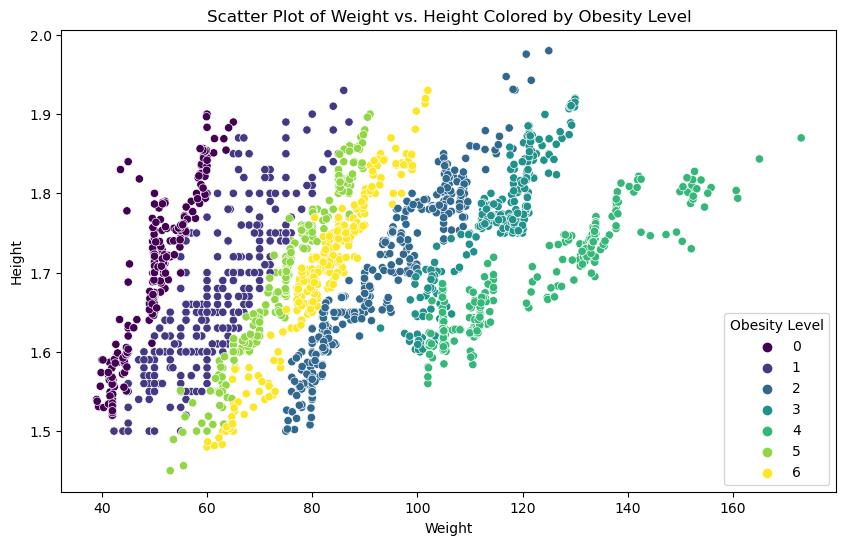

In [2]:
# Fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# Data 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

# Drop categorical columns
string_columns = ['MTRANS', 'Gender', 'family_history_with_overweight', 'FAVC', 'CALC', 'SCC', 'SMOKE', 'CAEC']
X = X.drop(string_columns, axis=1)

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y).ravel()

# Create DataFrame from X
df_X = pd.DataFrame(X, columns=['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])

# Add the obesity label column
df_X['Obesity'] = y  

# Proceed with plotting
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df_X, x='Weight', y='Height', hue='Obesity', palette='viridis')

# Adding plot labels and title
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Scatter Plot of Weight vs. Height Colored by Obesity Level')
plt.legend(title='Obesity Level')

# Show the plot
plt.show()

# Standardization
mu = X.mean()
stdu = X.std()
X = (X - mu) / stdu

X = X.to_numpy()

## Custom Multiclass Logistic Regression

We do the following:

- We implement the **softmax function**, which is used to convert the raw scores (logits) into probabilities that sum up to 1. This function ensures that each output can be interpreted as a probability for each class.

- **Cross Entropy Loss Calculation (cross_entropy_loss Method)**, which is a common loss function for classification problems, especially with softmax output. It measures the difference between the true class labels (in one-hot encoded form) and the predicted probabilities.
Includes a small constant (1e-15) to the logarithm argument to prevent log(0) and ensure numerical stability.
- **Model Fitting (fit Method):** One-hot encoding for the target variables (y_train and y_test) for training and testing datasets. <br>
It randomly initializes the weights. Then, it teratively updates the weights using stochastic gradient descent (SGD) by sampling one example at a time and adjusting the weights based on the gradient of the loss with respect to the weights.<br>
At the end of each epoch it computes and records the training and testing losses.

- **Predictions (predict Method)**:
For a given input matrix X, it augments it with a bias term, it computes the softmax probabilities using the learned weights, and then returns the class with the highest probability for each instance.

In [3]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate, num_iterations):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.losses_train = []  # for training loss
        self.losses_test = []  # for testing loss

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
        return loss


    def fit(self, X_train, y_train, X_test, y_test):
        # One-hot encode y
        y_train_one_hot = np.eye(np.unique(y_train).shape[0])[y_train]
        y_test_one_hot = np.eye(np.unique(y_test).shape[0])[y_test]
        
        # Add bias term to both train and test sets
        X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        
        # Initialize weights
        self.weights = np.random.rand(X_train.shape[1], np.unique(y_train).shape[0])
        
        for epoch in range(self.num_iterations):
            for i in range(X_train.shape[0]):
                random_index = np.random.randint(X_train.shape[0])
                xi = X_train[random_index:random_index+1]
                yi = y_train_one_hot[random_index:random_index+1]

                # Calculate predictions
                predictions = self.softmax(np.dot(xi, self.weights))
                
                # Gradient of the cross-entropy loss with respect to weights
                gradient = np.dot(xi.T, (predictions - yi))
                
                # Update weights
                self.weights -= self.learning_rate * gradient
            
            # Calculate training loss
            predictions_train = self.softmax(np.dot(X_train, self.weights))
            loss_train = self.cross_entropy_loss(y_train_one_hot, predictions_train)
            self.losses_train.append(loss_train)
            
            # Calculate testing loss
            predictions_test = self.softmax(np.dot(X_test, self.weights))
            loss_test = self.cross_entropy_loss(y_test_one_hot, predictions_test)
            self.losses_test.append(loss_test)
            
            print(f"Epoch {epoch+1}, Training Loss: {loss_train}, Testing Loss: {loss_test}")

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        predictions = self.softmax(np.dot(X, self.weights))
        return np.argmax(predictions, axis=1)

    def plot_losses(self):
        plt.plot(self.losses_train, label='Training Loss')
        plt.plot(self.losses_test, label='Testing Loss')  
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.title('Training and Testing Loss over Epochs')
        plt.legend()
        plt.show()


## Training and Testing using custom Multiclass Logistic Regression

Epoch 1, Training Loss: 1.1549162018859997, Testing Loss: 1.1691449819369506
Epoch 2, Training Loss: 1.038142839648838, Testing Loss: 1.056779158293663
Epoch 3, Training Loss: 0.9693461253008046, Testing Loss: 0.9765079208873573
Epoch 4, Training Loss: 0.9268619259511204, Testing Loss: 0.9456036455517488
Epoch 5, Training Loss: 0.8808240053547799, Testing Loss: 0.8939751513808395
Epoch 6, Training Loss: 0.8501866725984404, Testing Loss: 0.8573977559153382
Epoch 7, Training Loss: 0.826362980103815, Testing Loss: 0.8376229437819622
Epoch 8, Training Loss: 0.8034744915107485, Testing Loss: 0.8107936259796387
Epoch 9, Training Loss: 0.7824268398245634, Testing Loss: 0.7863041687779013
Epoch 10, Training Loss: 0.760623862981323, Testing Loss: 0.7758778497907441
Epoch 11, Training Loss: 0.7502564165055156, Testing Loss: 0.7626116700861612
Epoch 12, Training Loss: 0.7389618564738789, Testing Loss: 0.7480629719031301
Epoch 13, Training Loss: 0.7184170933286148, Testing Loss: 0.7228992104584424

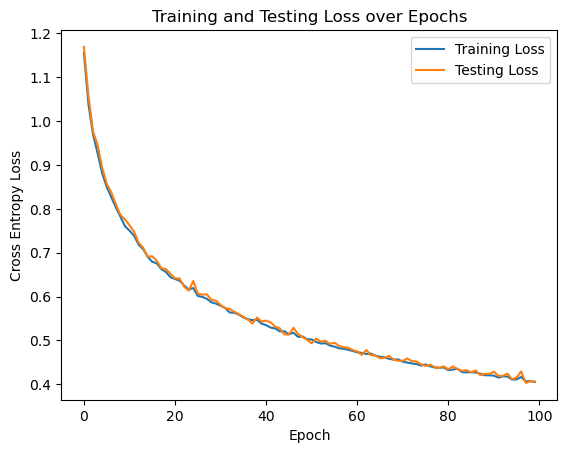

Accuracy on the custom model training set: 0.909952606635071
Accuracy on the custom model test set: 0.8888888888888888
Classification report for Custom Logistic Regression at Testing
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        56
           1       0.86      0.81      0.83        62
           2       0.96      0.92      0.94        78
           3       0.94      1.00      0.97        58
           4       0.97      1.00      0.98        63
           5       0.72      0.70      0.71        56
           6       0.81      0.76      0.78        50

    accuracy                           0.89       423
   macro avg       0.88      0.88      0.88       423
weighted avg       0.89      0.89      0.89       423



In [4]:
np.random.seed(42)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the logistic regression model
lr = MulticlassLogisticRegression(learning_rate=0.01, num_iterations=100)
lr.fit(X_train, y_train, X_test, y_test) 

# Make predictions on both the TRAINING and TEST sets
y_train_pred_custom = lr.predict(X_train)
y_test_pred_custom = lr.predict(X_test)

# Plot the losses for the training process
lr.plot_losses()

# Evaluate and print the accuracy on the TRAINING set
accuracy_train = accuracy_score(y_train, y_train_pred_custom)
print(f"Accuracy on the custom model training set: {accuracy_train}")

# Evaluate the accuracy on the TEST set 
accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
print(f"Accuracy on the custom model test set: {accuracy_custom}")

# Classification report on the test set
print("Classification report for Custom Logistic Regression at Testing")
print(classification_report(y_test, y_test_pred_custom))


## Training and Testing using LogisticRegression from scikit-learn

In [5]:

# Train scikit-learn's logistic regression model on the training set
log = LogisticRegression()
log.fit(X_train, y_train)  

# Make predictions on both the training and test sets
y_train_pred_sklearn = log.predict(X_train)
y_test_pred_sklearn = log.predict(X_test)

# Evaluate and print the accuracy on the TRAINING set
accuracy_train_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
print(f"Accuracy on scikit-learn's model training set: {accuracy_train_sklearn}")

# Evaluate and print the accuracy on the TESTING set
accuracy_test_sklearn = accuracy_score(y_test, y_test_pred_sklearn)
print(f"Accuracy on scikit-learn's model test set: {accuracy_test_sklearn}")

# Classification report for scikit-learn's Logistic Regression
print("Classification report for Logistic Regression from scikit-learn on Test Set")
print(classification_report(y_test, y_test_pred_sklearn))


Accuracy on scikit-learn's model training set: 0.879739336492891
Accuracy on scikit-learn's model test set: 0.8628841607565012
Classification report for Logistic Regression from scikit-learn on Test Set
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        56
           1       0.94      0.76      0.84        62
           2       0.97      0.90      0.93        78
           3       0.92      1.00      0.96        58
           4       0.97      1.00      0.98        63
           5       0.64      0.64      0.64        56
           6       0.66      0.70      0.68        50

    accuracy                           0.86       423
   macro avg       0.85      0.86      0.85       423
weighted avg       0.87      0.86      0.86       423

